<a href="https://colab.research.google.com/github/Sean-Wu-TW/257-Group-Project/blob/main/Yathukulan/Resnet34_facemask_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "/content/drive/MyDrive/CMPE257projectdata"

/content/drive/MyDrive/CMPE257projectdata


In [ ]:
ls

maskdata/  masks2.0/  savedmodel


In [ ]:
import os
import pandas as pd
import numpy as np
from fastai.callbacks.hooks import *

import cv2
import torch

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from fastai import *
from fastai.vision import *

#### check if CUDA is avaialble

In [ ]:
torch.__version__

'1.7.0+cu101'

In [ ]:
torch.version.cuda

'10.1'

In [ ]:
#if using google colab: set runtime to GPU
torch.cuda.is_available()

True

In [ ]:
!nvidia-smi

Mon Nov 23 23:49:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Load the data as an Image data bunch

In [ ]:
path = Path('/content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata')
path.ls()

[PosixPath('/content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata/train'),
 PosixPath('/content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata/test')]

In [ ]:
CONST_IMG_DIMENSION =224 #=224 = 32 * 7 

#we need 244 x 244 img for the given kernel size of 7x7 of resnet34 
#why? https://www.sicara.ai/blog/2019-10-31-convolutional-layer-convolution-kernel , 
#https://github.com/albanie/convnet-burden/blob/master/reports/resnet34.md#:~:text=Report%20for%20resnet34&text=Estimates%20for%20a%20single%20full,required%20for%20features%3A%2035%20MB
#https://cv-tricks.com/keras/understand-implement-resnets/

#try without resize squish?
data = (ImageList.from_folder(path)
       .split_by_folder(train='train',valid='test')
       .label_from_folder()
       .transform(get_transforms(),size=CONST_IMG_DIMENSION,resize_method=ResizeMethod.SQUISH)
       .databunch(bs=10))
data

ImageDataBunch;

Train: LabelList (616 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
without_mask,without_mask,without_mask,without_mask,without_mask
Path: /content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata;

Valid: LabelList (198 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
with_mask,with_mask,with_mask,with_mask,with_mask
Path: /content/drive/MyDrive/CMPE257projectdata/maskdata/maskdata;

Test: None

In [ ]:
#check classes
data.classes

['with_mask', 'without_mask']

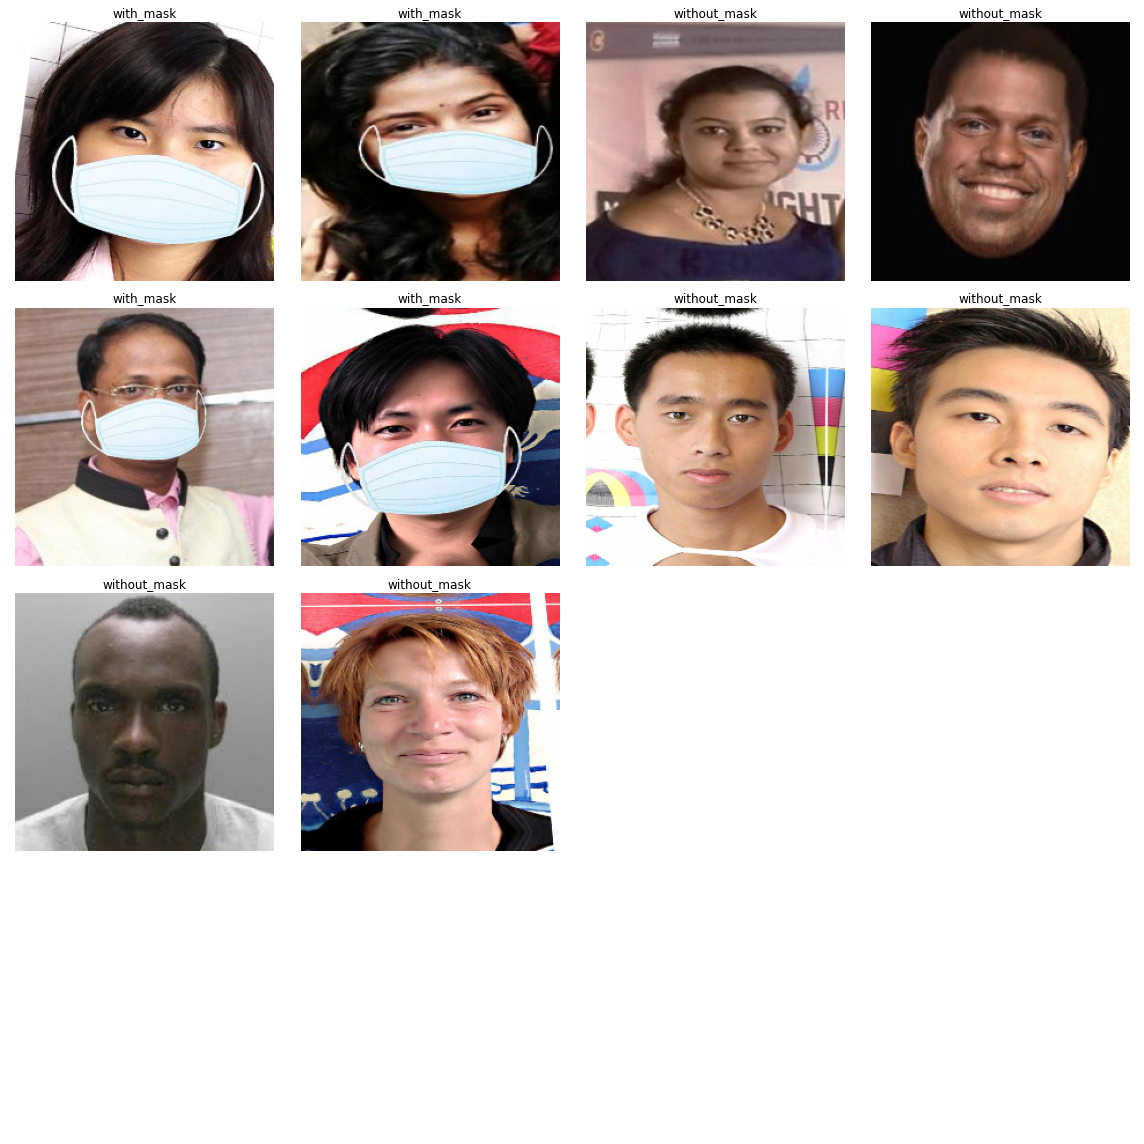

In [ ]:
data.show_batch()

#### Train Data

In [ ]:
resnet34_learn = cnn_learner(data,models.resnet34,metrics=[accuracy])
vgg19_bn_learn = cnn_learner(data,models.vgg19_bn,metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


In [ ]:
resnet34_learn.fit_one_cycle(cyc_len=4)
# more on the one cycle policy https://iconof.com/1cycle-learning-rate-policy/  https://arxiv.org/abs/1708.07120

In [ ]:
# vgg19_bn_learn.fit_one_cycle(cyc_len=4)

#### classification statistics

In [ ]:
def learnerinfo(learnobj):
  learnobj.recorder.plot_metrics()
  learnobj.recorder.plot_losses()
  learnobj.recorder.plot_lr()
  learnobj.recorder.plot()
  learnobj.summary()

In [ ]:
def show_stats_classif(learnobj):
  classif_int = ClassificationInterpretation.from_learner(learnobj)
  classif_int.plot_confusion_matrix()

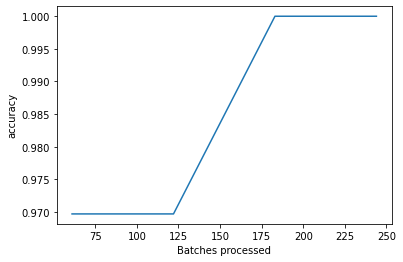

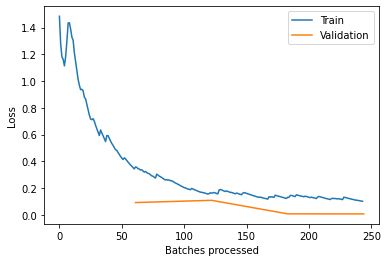

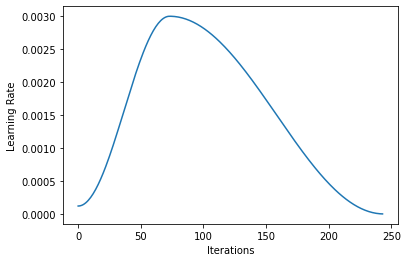

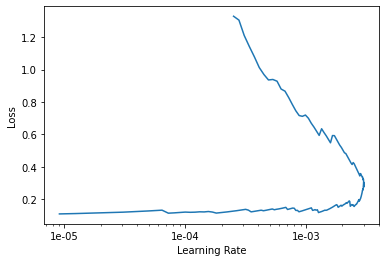

In [ ]:
learnerinfo(resnet34_learn)

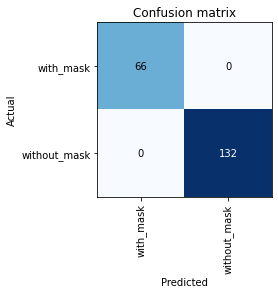

In [ ]:
show_stats_classif(resnet34_learn)

In [ ]:
model_resnet34=resnet34_learn.model.eval()

Classification: with_mask


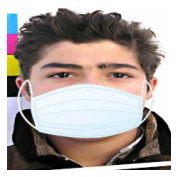

In [ ]:
#verify training data

picnum=300
img, classification = data.train_ds[picnum]
img.show()
print('Classification:', classification)
#data.valid_ds.y[picnum]

#### plot important features in an image according to activations and gradients

In [ ]:
#find hooks with backpropagation
#more on hooks: https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html

def find_backward_hooks(img_tensor, classification, model):
    with hook_output(model[0]) as hook_acts: #returns activations
        with hook_output(model[0], grad=True) as hook_grads: #returns gradients
            preds = model(img_tensor)
            preds[0,int(classification)].backward() #backprop
    return hook_acts,hook_grads

In [ ]:
#plot a heatmap of features
def plot_heatmap(tensor_inp, image, title):
    _,ax = plt.subplots()
    image.show(ax)
    ax.imshow(tensor_inp, alpha=0.6, extent=(0,CONST_IMG_DIMENSION,CONST_IMG_DIMENSION,0),
              interpolation='bilinear', cmap='seismic');
    plt.title(title)

In [ ]:
#find important features and overlay them on the image
def find_feature_importance(img, classification, model):
  

  img_tensor,_ = data.one_item(img)
  image = Image(img_tensor.view(3,CONST_IMG_DIMENSION,CONST_IMG_DIMENSION))

  img_tensor = img_tensor.cuda() # .cuda() transfers a tensor from CPU to GPU 

  hook_acts,hook_grads = find_backward_hooks(img_tensor=img_tensor, classification=classification, model=model)

  acts  = hook_acts.stored[0].cpu() # .cpu() transfers a tensor from GPU to CPU 
  acts_avg = acts.mean(0) #find the mean of activations per each lcoation

  grads = hook_grads.stored[0].cpu()
  grads = grads[0]
  grads_avg = grads.mean(0)

  plot_heatmap(acts_avg, image,'heatmap of activations')

  plot_heatmap(grads_avg, image, 'heatmap of gradients')


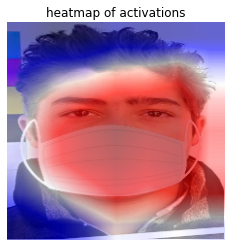

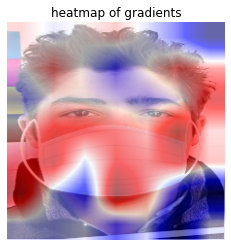

In [ ]:
find_feature_importance(img, classification,model_resnet34)

#### Classify unseen input

In [ ]:
model_resnet34.model_dir ='/content/drive/MyDrive/CMPE257projectdata/model/resnet34' #save model parameters to this dir

In [ ]:
def challenge (inp_path, model, learnerobj):
  challenge_img = open_image(inp_path)
  challenge_img.show(figsize=(10,10))

  classification, *_= learnerobj.predict(challenge_img)
  print(classification)

  find_feature_importance(challenge_img, classification, model)

without_mask


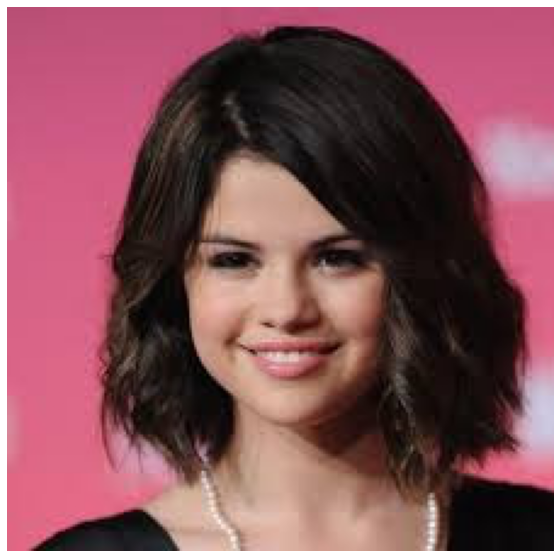

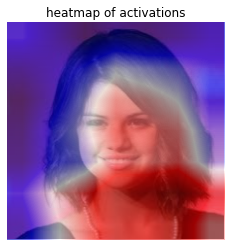

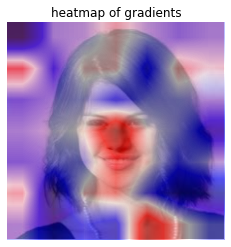

In [ ]:
path = '/content/drive/MyDrive/CMPE257projectdata/masks2.0/masks/test/0/11.jpg'
challenge(path, model_resnet34, resnet34_learn)

with_mask


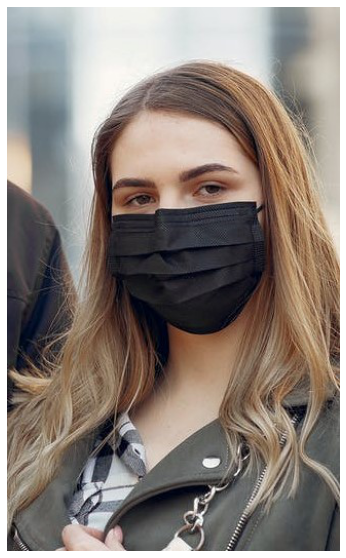

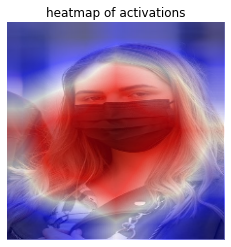

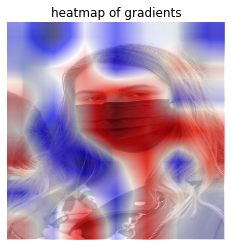

In [ ]:
path = '/content/drive/MyDrive/CMPE257projectdata/masks2.0/masks/test/1/7 w.jpeg'
challenge(path, model_resnet34, resnet34_learn)

with_mask


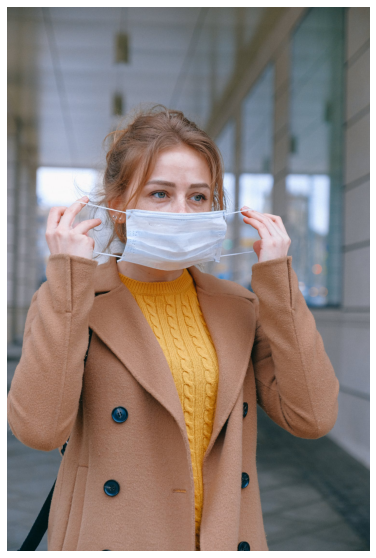

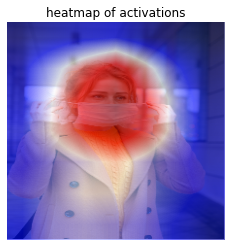

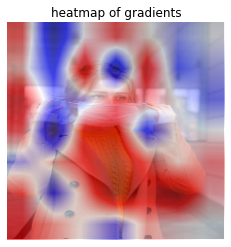

In [ ]:
path = '/content/drive/MyDrive/CMPE257projectdata/masks2.0/masks/test/1/9.jpeg'
challenge(path, model_resnet34, resnet34_learn)

with_mask


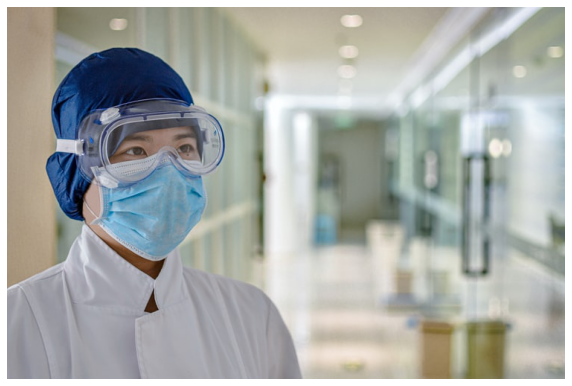

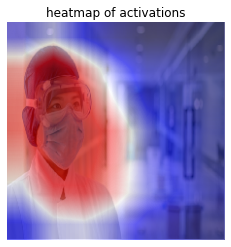

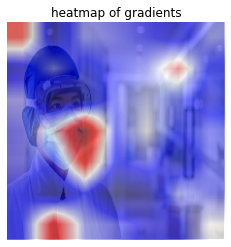

In [ ]:
path = '/content/drive/MyDrive/CMPE257projectdata/masks2.0/masks/train/1/16.jpg'
challenge(path, model_resnet34, resnet34_learn)

without_mask


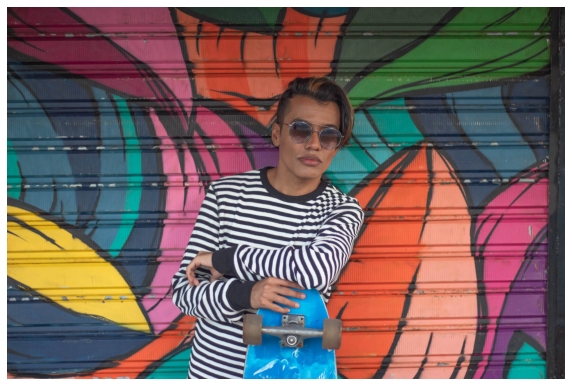

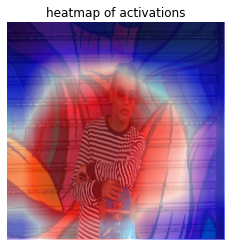

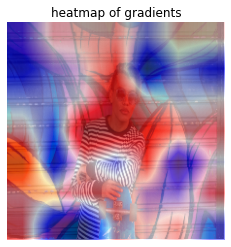

In [ ]:
path = '/content/drive/MyDrive/CMPE257projectdata/masks2.0/masks/train/0/pexels-photo-4048805.jpeg'
challenge(path, model_resnet34, resnet34_learn)

In [ ]:
model_resnet34.parameters

<bound method Module.parameters of Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

In [ ]:
resnet34_learn.export(Path('/content/drive/MyDrive/CMPE257projectdata/savedmodel'))